### Capstone Milestone Report

# Ontario Energy Use: Predicting demand from weather and population data

### * James Parks *

# Table of Contents

## 1. Introduction
- Discuss the problem, give more background on where it comes from and why we care.
- Discuss the client and why they would care about this project.

## 2. Import Data
- Import data for Energy Demand, Energy Price, Import and Export data, population data and weather data.
- Explain what each of these variables is

## 3. Exploratory Data Analysis
- Investigate average monthly temperature, average monthly demand, average monthly price
- Investigate the relationships between temperature and demand, hmdx and demand and price and demand, population and demand (Hypothesis testing)
- Look for trends in demand for Daily, Weekly, Monthly and Yearly
- Do more Time Series analysis here for rolling averages and other resampling
- Look hour sharp hourly changes in temperature, price, etc affect demand, does the demand drop / increase?
- Group data by month, day and hour and find demand average. Then look for times when demand was very far from the mean
- Investigate outliers for temperature vs demand and price vs demand
- Look into forecasting demand for the month of August and compare at the end of the month


## 4. Missing Data
- Use interpolation to fill in the missing data for the important columns.
- Look at other outliers + VIF Variance Inflation Factor

## 5. Machine Learning Modeling
- Build regression function
- Perfrom Linear Regression, Random Forest Regression, Ridge Regression, Lasso Regression, Elastic Net, Support Vector Regression, k-Nearest Neighbors Regression, Gradient Boosted Regression, Neural Network
- Interpret models and find best one
- Try various train-test splits
- Use cross-validation with K-Fold
- Employ regularization reductions (checks for outfitting?)
- Principle Component Analysis

## 6. Conclusion
- Write conclusion of findings.

# 1. Introduction - The Problem

Ontarians use more than 140 million megawatt hours of electricity a year to run their homes, businesses, hospitals, schools, transit and infrastructure. Ensuring there is enough energy to meet Ontario’s needs 24 hours a day, 7 days a week, requires the close co-ordination of the many moving and integrated parts of the electricity system. 

We know that price and supply can play a large role in demand for a product and that includes energy. It’s clear that weather and population play a huge influence in the demand for energy as well. In order to meet client demands for electricity, energy companies need a robust model. More energy is typically demanded during the day than t night when people are sleeping, but since the change in weather can also affect changes in demand for energy, companies need to be able to anticipate large spikes in demand in order to prevent blackouts.

Planning is essential to a reliable, sustainable electricity future. The IESO plans and prepares for Ontario's electricity needs by assessing electricity requirements for the power system of today and tomorrow as well as planning to ensure electricity will be available when and where it is needed.

The IESO continually produces forecasts of expected demand and available generation, for weeks and days ahead, which take into account: the day of the week, detailed weather forecasts, historical demand, embedded (or distribution-connected) generation, system conditions and special events or holidays.

In this project we look at the historical hourly energy demand of Ontario, Canada from 1994 until August 2017, the historical energy price, the historical population as well as the historical hourly weather data for Toronto from the same time period.

**The Goal**: Develop a model that predicts energy demand based on weather, price and population data. 

# The Client

The Independent Electricity System Operator (IESO) works at the heart of Ontario's power system as the system operator—directing the flow of electricity across the grid and administering the wholesale electricity market. It sets the hourly Ontario electricity price and ensures there is enough power to meet the province's energy needs in real time. The IESO works with stakeholders and communities across the province to plan and secure energy for the future, as well as guide the conservation efforts in Ontario. 

The client in this case is the IESO, connecting generators and suppliers that sell electricity and wholesale consumers who purchase it. Ontario’s real-time electricity market is a 24/7 operation, with the intersection between offers to supply electricity and bids to consume setting a wholesale price every five minutes.. Having a more robust model for determining just how much changes in weather affect energy demand can be extremely beneficial in saving money and preventing blackouts. Based on this analysis they will be better able to adjust supply to meet expected demands with the changes of seasonal weather. 

Note that although this data is only for Ontario, the analysis may also be of benefit to other regions with similar weather patterns and populations.

# 2. Imports

In [1]:
#Usual imports
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 3. The Data

The Data comes from three sources.

- Independent Electricity System Operator, http://www.ieso.ca/power-data which has .csv files for the hourly energy demand for the province of Ontario from 1994- August 2017, hourly price from 2002 to 2017 and hourly import and export data.
  
- Environment Canada, which has .csv files for the hourly weather data for many locations in Ontario for the same time period. To start with we choose the data for Toronto, since its urban area accounts for a large percentage of the population of Ontario and we make the assumption that its energy demand will contribute to the largest demand in the province.

- Wikipedia, which has the population data for Ontario and Toronto for the years 1996, 2001, 2006, 2011 and 2016. We will use linear interpolation to estimate the approximate population for the intermediate time periods.

## First we import the energy, price and import/export hourly data

In [2]:
#Import the energy data
energy_data_old=pd.read_csv("data\HourlyDemands_1994-2002.csv")
energy_data_recent=pd.read_csv("data\HourlyDemands_2002-2016.csv")
energy_data_this_year=pd.read_csv("data\HourlyDemands.csv")

In [3]:
# Create common columns for all three dataframes
energy_data_old=energy_data_old.rename(columns={'OntarioDemand': 'Ontario Demand'})
energy_data_old['Date']= pd.DatetimeIndex(energy_data_old['DateTime']).date
energy_data_old['Hour']= pd.DatetimeIndex(energy_data_old['DateTime']).hour
energy_data_recent['Date']= pd.DatetimeIndex(energy_data_recent['Date']).date
energy_data_this_year['Date']= pd.DatetimeIndex(energy_data_this_year['Date']).date

In [4]:
#Import the price and import/export data
price_data_this_year=pd.read_csv("data\HOEP.csv")
price_data_past= pd.read_csv("data\HOEP_2002-2016.csv")
imports_this_year=pd.read_csv("data\HourlyImportExportSchedules.csv")
imports_past=pd.read_csv("data\HourlyImportExportSchedules_2002-2016.csv")
# Convert Date columns to datetime 
price_data_this_year['Date']= pd.DatetimeIndex(price_data_this_year['Date']).date
price_data_past['Date']= pd.DatetimeIndex(price_data_past['Date']).date
imports_this_year['Date']= pd.DatetimeIndex(imports_this_year['Date']).date
imports_past['Date']= pd.DatetimeIndex(imports_past['Date']).date

In [5]:
# Join price and imports/exports dataframes together
price_all=pd.concat([price_data_this_year,price_data_past])
imports_all=pd.concat([imports_this_year,imports_past])
price_import=price_all.merge(imports_all,left_on=["Date","Hour"],right_on=["Date","Hour"], how="outer")
# Join all three demand dataframes together and create a standard datetime column
energy_data_all=pd.concat([energy_data_old,energy_data_recent,energy_data_this_year])
# Join demand with price and imports/exports data
df_elect=energy_data_all.merge(price_import,left_on=["Date","Hour"],right_on=["Date","Hour"], how="outer")
df_elect["Date/Time"]=pd.to_datetime(df_elect.Date) + df_elect.Hour.astype('timedelta64[h]')

In [6]:
df_elect_all=df_elect.sort_values(by=["Date/Time"]).drop("DateTime",axis=1)
df_elect_all.tail(10)

,Date,Hour,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Date/Time
206918,2017-09-09,15,12407,14723.0,2.19,213,"2,384",2017-09-09 15:00:00
206919,2017-09-09,16,12714,14808.0,6.67,216,"2,161",2017-09-09 16:00:00
206920,2017-09-09,17,13103,14988.0,9.64,194,"1,941",2017-09-09 17:00:00
206921,2017-09-09,18,13483,15300.0,11.37,165,"1,869",2017-09-09 18:00:00
206922,2017-09-09,19,13862,15667.0,12.55,607,"1,871",2017-09-09 19:00:00
206923,2017-09-09,20,14116,15614.0,10.34,591,"1,525",2017-09-09 20:00:00
206924,2017-09-09,21,13475,14998.0,5.42,636,"1,544",2017-09-09 21:00:00
206925,2017-09-09,22,12724,14558.0,6.52,247,"1,857",2017-09-09 22:00:00
206926,2017-09-09,23,11912,14077.0,9.62,212,"2,208",2017-09-09 23:00:00
206927,2017-09-09,24,11311,13375.0,2.04,170,"2,082",2017-09-10 00:00:00


## Import the weather data

In [7]:
# We make a single dataframe from all the csv files in the csv folder
path = "./csv/"
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']
weather_data=pd.DataFrame()
for f in files_csv:
    data = pd.read_csv(path+f,skiprows=16)
    weather_data = weather_data.append(data)

In [8]:
weather_data.head(4)

,Date/Time,Year,Month,Day,Time,Data Quality,Temp (°C),Temp Flag,Dew Point Temp (°C),Dew Point Temp Flag,...,Wind Spd Flag,Visibility (km),Visibility Flag,Stn Press (kPa),Stn Press Flag,Hmdx,Hmdx Flag,Wind Chill,Wind Chill Flag,Weather
0,2002-10-01 00:00,2002,10,1,00:00,,19.5,NaN,16.9,NaN,...,M,NaN,M,100.18,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-10-01 01:00,2002,10,1,01:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.19,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-10-01 02:00,2002,10,1,02:00,,19.1,NaN,17.3,NaN,...,M,NaN,M,100.17,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-10-01 03:00,2002,10,1,03:00,,19.2,NaN,17.2,NaN,...,M,NaN,M,100.14,NaN,NaN,NaN,NaN,NaN,NaN


## Import the population data

Note that this data comes from Wikipedia, but only contains population data for the years 1996,2001,2006,2011 and 2016. We will use interpolation to estimate the populations for the years between.

In [9]:
pop_data=pd.read_excel("ontario_pop.xlsx")
# Convert Date column to datetime
pop_data["Date"]=pd.to_datetime(pop_data.Date)
# create a datetime column for the years between 1994 and 2017
date_index = pd.DataFrame({"Date/Time":pd.date_range('1/1/1994', periods=len(weather_data), freq='H')})
# Merge date_index dataframe with the the population data dataframe
pop_merged=date_index.merge(pop_data,left_on="Date/Time",right_on="Date",how="outer")
# Subset on useful columns
pop_merged=pop_merged[["Date/Time", "Ontario_pop","Toronto_pop"]]
# Use linear interpolation to estimate the hourly population between offical census data
pop_merged.interpolate(method='linear',limit_direction="both",inplace=True)
# Round population estimates to the nearest integer
pop_merged[["Ontario_pop","Toronto_pop"]]=pop_merged[["Ontario_pop","Toronto_pop"]].round()

In [10]:
# We merge the electricity and weather dataframes together
weather_data["Date/Time"]=pd.to_datetime(weather_data["Date/Time"])
weather_merge=pd.merge(weather_data,df_elect_all, how="outer",left_on="Date/Time",right_on="Date/Time")
# Now merge with the populaton dataframes
all_data=pd.merge(weather_merge,pop_merged, how="outer",left_on="Date/Time",right_on="Date/Time")

In [11]:
# Convert Import and Export columns to numerical
all_data["Imports"]=all_data.Imports.replace({",":""}, regex=True)
all_data["Imports"]=pd.to_numeric(all_data.Imports, errors='coerce')
all_data["Exports"]=all_data.Exports.replace({",":""}, regex=True)
all_data["Exports"]=pd.to_numeric(all_data.Exports, errors='coerce')

In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 207673 entries, 0 to 207672
Data columns (total 34 columns):
Date/Time              207673 non-null datetime64[ns]
Year                   207456 non-null float64
Month                  207456 non-null float64
Day                    207456 non-null float64
Time                   207456 non-null object
Data Quality           205294 non-null object
Temp (°C)              205284 non-null float64
Temp Flag              10 non-null object
Dew Point Temp (°C)    205284 non-null float64
Dew Point Temp Flag    10 non-null object
Rel Hum (%)            205284 non-null float64
Rel Hum Flag           10 non-null object
Wind Dir (10s deg)     69305 non-null float64
Wind Dir Flag          130567 non-null object
Wind Spd (km/h)        75005 non-null float64
Wind Spd Flag          130618 non-null object
Visibility (km)        73619 non-null float64
Visibility Flag        21006 non-null object
Stn Press (kPa)        199629 non-null float64
Stn Press Fla

## Weather and Population Variable Descriptions

** Date/Time:** Date and Time given in local Eastern Time.

** Data Quality: ** Is either ' ' if there is no problems with the data quality or nan if the weather data is missing.

** Temp (°C): ** The hourly temperature give in celsius.

** Temp Flag, Dew Point Temp Flag, Rel Hum Flag, Wind Dir Flag, Visibility Flag, Stn Press Flag, Hmdx Flag or Wind Chill Flag: ** Is either 'M' or nan if the corresponding feature is missing.

** Dew Point Temp (°C): ** is the temperature to which air must be cooled to become saturated with water vapor. A high relative humidity implies that the dew point is closer to the current air temperature.

** Rel Hum (%): ** is the ratio of the partial pressure of water vapor to the equilibrium vapor pressure of water at a given temperature. It requires less water vapor to attain high relative humidity at low temperatures; more water vapour is required to attain high relative humidity in warm or hot air.

** Wind Dir (10s deg): ** is the direction from which the wind originates. It is measured on a scale of 0 to 360° in 10 degree increments. Here North is between 35. and 1. 

** Wind Spd (km/h): ** is the wind speed given in kilometers / hour.       75005 non-null float64

** Wind Spd Flag: ** Is either 'M' or nan if the corresponding feature is missing or 'E' if the speed is given, but not the direction.

** Visibility (km): ** is a measure of the distance at which an object or light can be clearly discerned, given in kilometers.

** Stn Press (kPa): ** is the atmospheric pressure given in kiloPascals.

** Hmdx: ** is an index number used by Canadian meteorologists to describe how hot the weather feels to the average person, by combining the effect of heat and humidity. A formula for Hmdx based on the dew point temperature is given in a later section.

** Wind Chill: ** is the perceived decrease in air temperature felt by the body on exposed skin due to the flow of air.
Wind chill numbers are always lower than the air temperature for values where the formula is valid.

** Weather: ** describes the type of weather. (E.g. rainy, snowy, sunny, cloudy etc.)

** Ontario_pop: ** Estimated population of Ontario for that hour.

** Toronto_pop: ** Estimated population of Toronto for that hour.



## Energy Demand and Price Variable Descriptions

The IESO accepts the lowest-cost offers to supply electricity until sufficient megawatts are available to meet Ontario’s demand. The IESO then dispatches generators and importers to provide electricity based on their accepted offers. Some types of generators are more expensive to operate than others − as a result, the wholesale price of electricity rises as more expensive forms of generation are brought online to meet demand. A new market clearing price for electricity is set every five minutes.

** Ontario Demand: ** The amount of power measured in Megawatts consumed throughout Ontario for that hour. Total Ontario electricity demand is calculated as: 

$$\text{Total Energy }+\text{ Total Generation Without Offers }-\text{ Total Exports }+\text{ Total Off Market }+/- \text{ Over/Under Generation}.$$ 
where
- *Total Energy* is the total energy dispatched into the IESO controlled grid, calculated as Ontario generation plus imports.
- *Total Generation Without Offers* is the total energy injected into the IESO controlled grid from generators that have not submitted offers.
- *Total Exports* is the total energy dispatched outside Ontario from the IESO controlled grid.
- *Total Off Market* consists of transactions related to Segregated Mode of Operation, Emergency, Simultaneous Activation of Reserve and Inadvertent Interchange.  
- *Over/Under Generation* is the total energy resulting from over or under generation in the event of differences when the Dispatch Scheduling and Optimization (DSO) tool is balancing supply and demand.

** Total Market Demand: ** is given by Total Energy + Total Generation Without Offers described above. 

** Imports: ** is the total energy injected into the IESO controlled grid from generators outside Ontario.

** Exports: ** is given by Total exports as described above.

** HOEP: ** is the hourly Ontario wholesale energy market price given in ($/MWh). A Megawatt hour is the amount of power consumed measured in Megawatts in one hour. The average of the twelve market clearing prices set in each hour is called the Hourly Ontario Energy Price, or HOEP. The HOEP is charged to large consumers that participate in the market, as well as local distribution companies (LDCs) who in turn recover it from business customers that pay the wholesale market price.

The wholesale market price represents the cost of producing electricity in real time, based on changing supply and demand. The price does not include the cost of transporting electricity across the province or longer-term fixed costs such as building and financing grid infrastructure. These costs are recovered outside of the wholesale electricity market.





# 4. Exploratory Data Analysis

## Investigate monthly temperature average

In [13]:
yearly_avg=all_data.groupby(["Year","Month"]).mean().reset_index()
yearly_avg["year/month"]=pd.to_datetime(yearly_avg[["Year","Month","Day"]])

In [14]:
def line_plot(df,ind,dep,label_name,title_name,plot_color):
    fig,ax = plt.subplots(figsize=(12,9))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.plot(df[ind], df[dep], color=plot_color, linewidth=0.8,label=label_name)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.legend()
    plt.show()

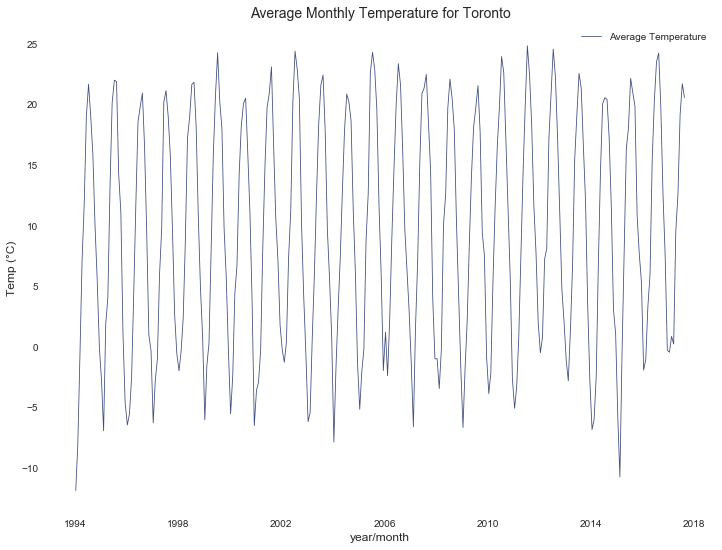

In [15]:
line_plot(yearly_avg,"year/month","Temp (°C)", "Average Temperature",'Average Monthly Temperature for Toronto',"#3F4D7D")

** Here we see that monthly average temperatures have not changed too dramatically over the years. The winters of 2014 and especially 2015 look to be outliers in the recent trend of warmer winters of the past six years. **

## Investigate average monthly energy demand

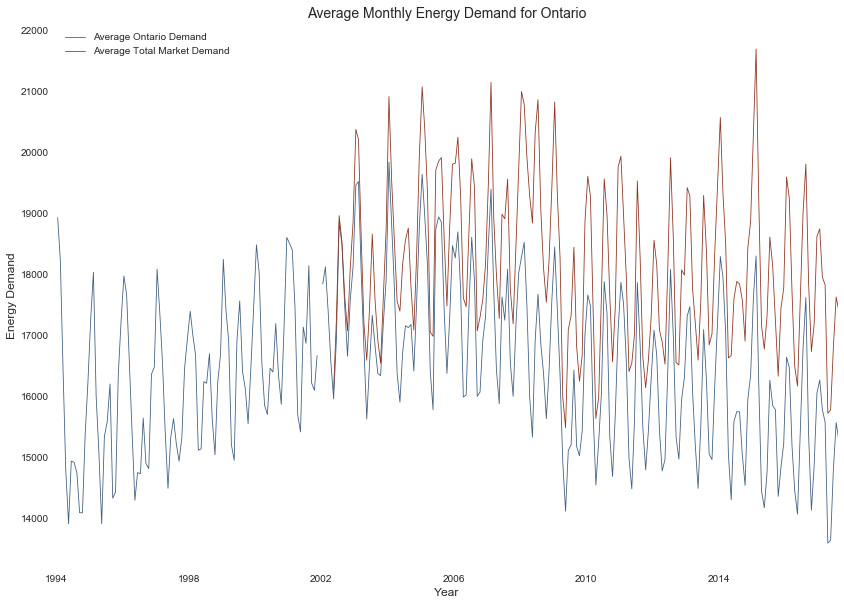

In [16]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.set_facecolor('white')
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(yearly_avg["year/month"], yearly_avg["Ontario Demand"], color="#3F5D7D", linewidth=0.8,label="Average Ontario Demand")
plt.plot(yearly_avg["year/month"], yearly_avg["Total Market Demand"], color="#8E3320", linewidth=0.8,label="Average Total Market Demand")
plt.xlabel('Year', fontsize=12)
plt.ylabel('Energy Demand', fontsize=12)
plt.title('Average Monthly Energy Demand for Ontario', fontsize=14)
plt.xlim(["1994-01-01","2017-07-31"])
plt.legend()
plt.show()

** The IESO opened the Ontario electricity market on May 1st 2002. (This is visible as the discontinuity in the graph) Afterwards there is both electricity demanded by Ontario as well as the Total Demand which also included energy exported to other regions. **

**If we look only at the Ontario energy demand we see that demand has been decreasing since the market opened even though the population has been increasing, which could be a result of higher prices to consumers or improvements in energy efficiency.  The IESO report that coal-fired generation has been phased out; wind and solar generation have joined the provincial supply mix; and new types of demand response and storage resources are also helping to meet the province's demand for electricity.**

** The drop in demand in 2009 could be a result of the recession. The weather could have been milder that year as well. The big spike in demand at the beginning of 2015 is almost certainly a result of the abnormally cold winter that year. **

## Investigate average monthly price

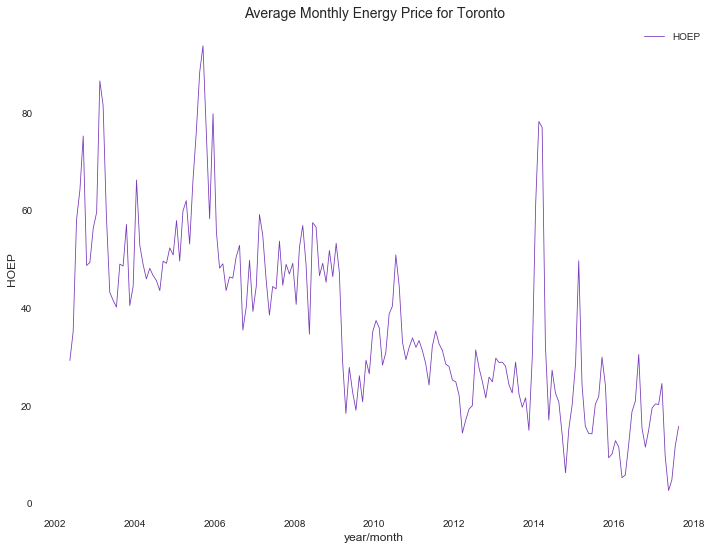

In [17]:
line_plot(yearly_avg,"year/month","HOEP", "HOEP",'Average Monthly Energy Price for Toronto', "#7739b8")

We see a general trend of decreasing average energy price, with a few very big spikes in 2005, 2014 and to a lesser extent in 2003 and 2015.

In [13]:
all_data.drop(["Year","Month","Day","Hour", "Hmdx Flag","Wind Chill Flag"],axis=1).describe()

,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Ontario_pop,Toronto_pop
count,205284.000000,205284.000000,205284.000000,69305.000000,75005.000000,73619.000000,199629.000000,32838.000000,16589.000000,206928.000000,134664.000000,134664.000000,134664.000000,134664.000000,2.074560e+05,2.074560e+05
mean,9.348264,3.801280,70.485518,22.444499,14.913232,21.264546,99.962070,29.852001,-11.868346,16438.955395,18196.415872,37.253889,819.498775,1684.291355,1.210313e+07,5.533069e+06
std,10.670415,10.206349,16.406300,9.895402,9.836360,9.570469,0.842069,3.807568,6.391140,2570.229182,2530.421406,34.864035,597.706193,876.115161,9.342699e+05,6.227322e+05
min,-30.300000,-36.100000,9.000000,1.000000,0.000000,0.000000,96.550000,25.000000,-40.000000,2270.000000,2270.000000,-138.790000,0.000000,0.000000,1.049127e+07,4.447904e+06
25%,1.300000,-3.600000,60.000000,14.000000,7.000000,16.100000,99.430000,27.000000,-16.000000,14513.000000,16306.000000,19.950000,330.000000,1058.000000,1.126775e+07,4.983648e+06
50%,9.500000,3.900000,72.000000,25.000000,13.000000,24.100000,99.980000,29.000000,-11.000000,16425.000000,18119.000000,32.100000,726.000000,1679.000000,1.213521e+07,5.540070e+06
75%,18.300000,12.300000,83.000000,31.000000,20.000000,25.000000,100.520000,32.000000,-7.000000,18224.000000,19880.000000,45.780000,1213.000000,2276.000000,1.294134e+07,6.108703e+06
max,37.400000,26.700000,100.000000,36.000000,76.000000,40.200000,102.980000,51.000000,-1.000000,27005.000000,27999.000000,1891.140000,4571.000000,5571.000000,1.364728e+07,6.538558e+06


Some interesting things to note is that the average temperature of Toronto is 9.5 °C and the average Pressure is 99.8 kPa, well below the standard temperature and pressure. Ontario Demand seems centered around 16425 MW with a ver low minimum and rather high maximum. These are possible outliers that we will investigate later. HOEP can lso be negative, which can occur when there is more energy being produced than expected and customers are being reimbursed for using energy. Also, the maximum HOEP looks rather high as well.

## Relationships between the various features

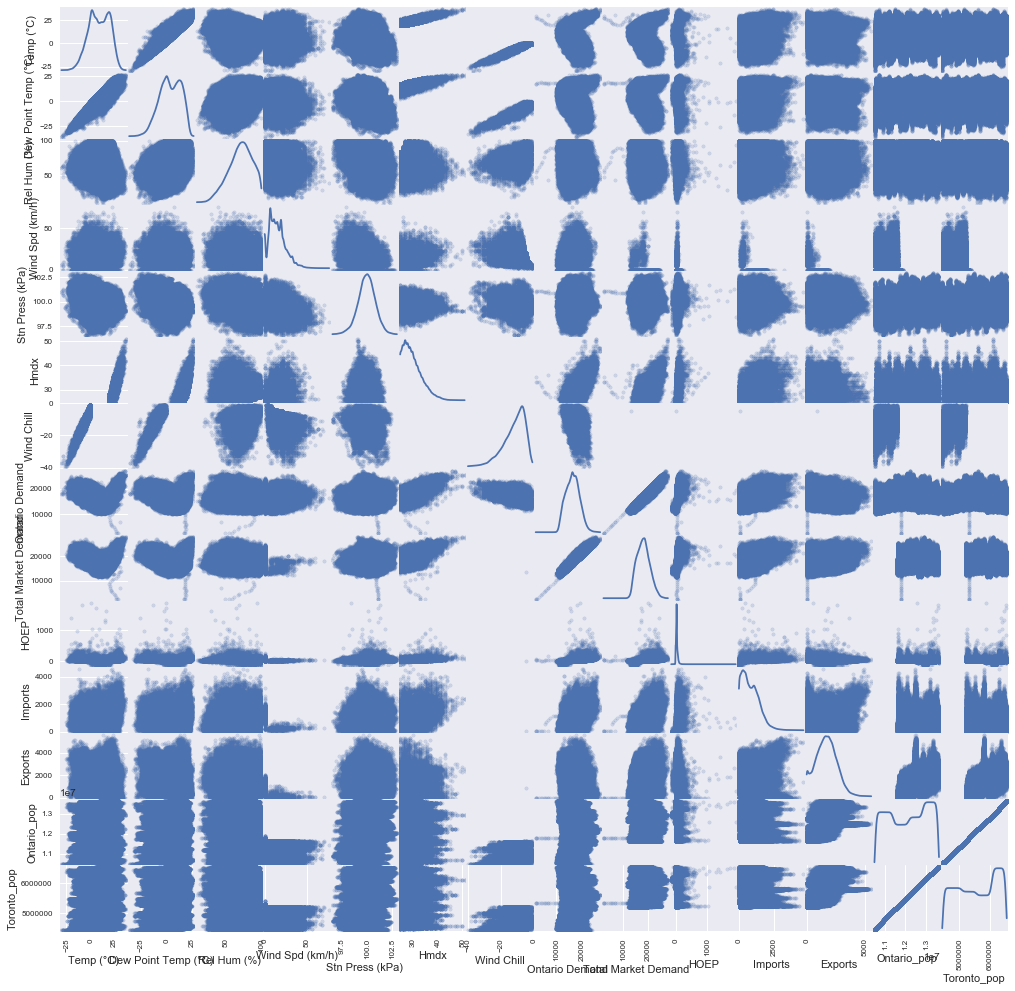

In [19]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(all_data.drop(["Year","Month","Day","Wind Dir (10s deg)","Visibility (km)","Hmdx Flag","Wind Chill Flag","Hour"],axis=1),alpha=0.2, figsize=(17, 17), diagonal='kde')
plt.show()

** Most of the variables are normally distributed. We see some suspicious outliers in the energy demand vs temperature and energy demand vs humidex scatter plots. Otherwise there is a very strong correlation between humidex and energy demand and energy demand and a non-linear relationship between temperature and energy demand. The non-linear nature is due to the large demand for heat when the temperature is very low and the large demand for cooling when the temperature is very high. **

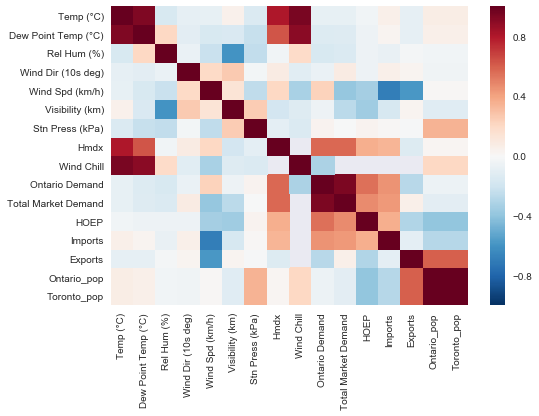

In [20]:
corr = all_data.drop(["Year","Month","Day","Hmdx Flag","Wind Chill Flag","Hour"],axis=1).corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

Here we see a strong positive correlation between humidex and energy demand as well as a subtle inverse relationship between demand and wind chill.Price and Imports also seem to have a strong positive relationship with demand. This seems to imply that when demand is higher then the price of energy is also higher. Likewise, when imports are high then price is higher and when exports are higher the price is lower. There is also a strong positive relationship between population and exports. Since the population of Ontario has only been growing with time this suggests that more and more energy is being exported every year.

In [21]:
def sc_plot(df,ind,dep, col_code,title_name):
    fig,ax = plt.subplots(figsize=(10, 8))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    plt.scatter(df[ind], df[dep], color=col_code)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.show()

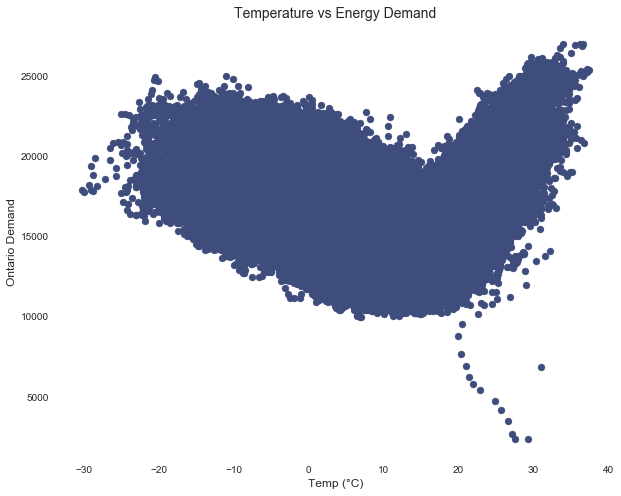

In [22]:
sc_plot(all_data,"Temp (°C)",'Ontario Demand', "#3F4D7D", 'Temperature vs Energy Demand')

There is a very clear distinctive relationship between temperature and energy demand. We see that energy demand increases slowly as temperature decreases from 15°C and increases more rapidly as temperature increases from 15 °C. There are also some clear outliers with very low Ontario Demand.

In [23]:
# Investigate which dates gave abnormally low values of demand.
low_energy=all_data[all_data["Ontario Demand"]<10000]
low_energy["Date/Time"].unique

<bound method Series.unique of 12760    2003-08-14 16:00:00
12761    2003-08-14 17:00:00
12762    2003-08-14 18:00:00
12763    2003-08-14 19:00:00
12764    2003-08-14 20:00:00
12765    2003-08-14 21:00:00
12766    2003-08-14 22:00:00
12767    2003-08-14 23:00:00
12768    2003-08-15 00:00:00
12769    2003-08-15 01:00:00
12770    2003-08-15 02:00:00
12771    2003-08-15 03:00:00
12772    2003-08-15 04:00:00
12773    2003-08-15 05:00:00
12774    2003-08-15 06:00:00
141843   1994-09-05 03:00:00
141844   1994-09-05 04:00:00
Name: Date/Time, dtype: datetime64[ns]>

On August 14, 2003, Ontario and the northeastern United States experience a large scale blackout. https://en.wikipedia.org/wiki/Northeast_blackout_of_2003 At the time, it was the world's second most widespread blackout in history.

** Note**: When investigating the remaining relationships, we remove the blackout hours from the visualization.

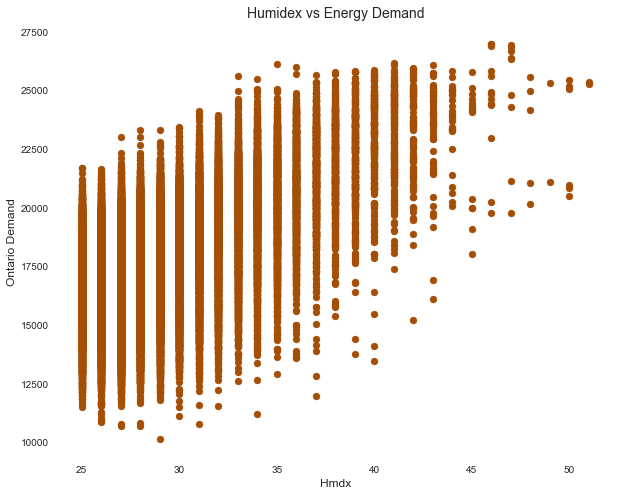

In [24]:
blackout_list=all_data[12760:12775].index
sc_plot(all_data.drop(blackout_list),"Hmdx",'Ontario Demand', '#a54e06', 'Humidex vs Energy Demand')

Here we see a slight postive relationship between Humidex and Energy demand. Since temperature is closely correlated with temperature we removed the blackout hours outliers that were detected above.

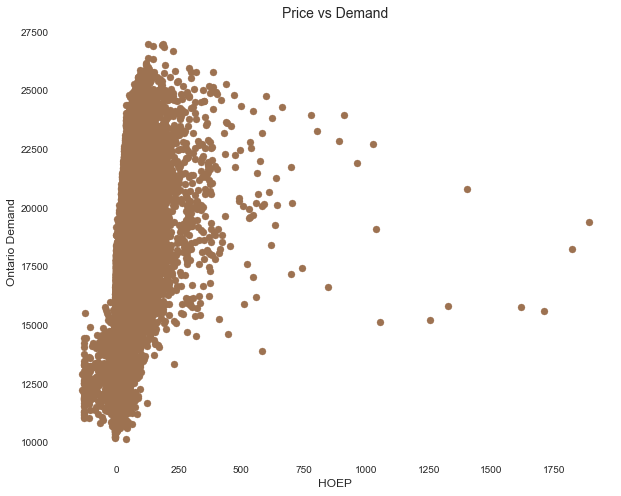

In [25]:
sc_plot(all_data.drop(blackout_list),"HOEP",'Ontario Demand', '#9d7251', 'Price vs Demand')

In this case we see a slight positive relationship between demand and price where when the price increases when the demand is higher although for the most part price changes very little regardless of the demand. Note that there are quite a few outliers with a very high HOEP.

In [26]:
# Investigate which dates gave abnormally high values of price.
high_price=all_data[all_data["HOEP"]>750]
high_price[["Date/Time","Temp (°C)","Ontario Demand","HOEP", "Imports","Exports"]].sort_values(by="HOEP",ascending=False)

,Date/Time,Temp (°C),Ontario Demand,HOEP,Imports,Exports
61116,2009-02-18 12:00:00,1.0,19413.0,1891.14,458.0,581.0
129548,2017-03-11 20:00:00,-8.5,18260.0,1822.95,960.0,2602.0
130304,2017-04-12 08:00:00,6.2,15591.0,1711.03,231.0,1822.0
125156,2016-06-09 20:00:00,16.5,15787.0,1619.60,671.0,1793.0
113744,2015-02-20 08:00:00,-20.7,20807.0,1402.44,344.0,3624.0
125157,2016-06-09 21:00:00,15.2,15826.0,1327.89,700.0,1617.0
115528,2015-05-05 16:00:00,15.2,15238.0,1255.89,1010.0,2067.0
111105,2015-10-02 09:00:00,8.8,15115.0,1053.11,1377.0,1755.0
61115,2009-02-18 11:00:00,1.6,19103.0,1039.27,329.0,1534.0
4478,2002-09-03 14:00:00,30.0,22718.0,1028.42,2329.0,3.0


On initial investigation it doesn't seem like there is anything particularly special about the dates or temperatures when the price was very high. 

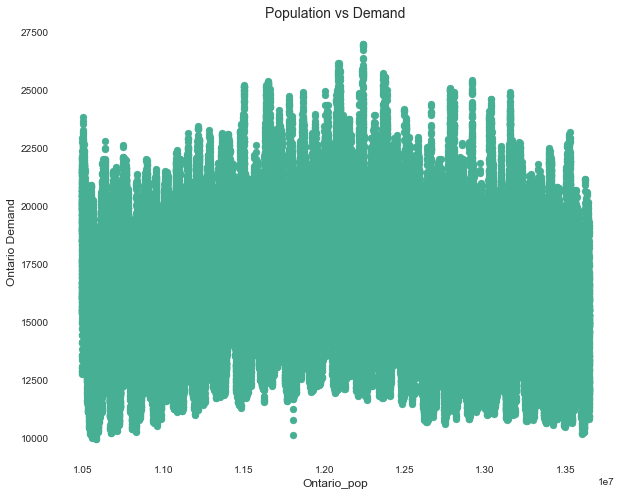

In [27]:
sc_plot(all_data.drop(blackout_list),"Ontario_pop",'Ontario Demand', '#47af94', 'Population vs Demand')

Since population is increasing over time, we see a slightly cyclical pattern to the relationship between demand and population, which was explained in the plot above of average monthly energy demand over time.

## Investigate Trends for different time periods

In [28]:
def bar_plot(df,ind,objects,dep,title_name,plot_color):
    fig,ax = plt.subplots(figsize=(14,8))
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.set_facecolor('white')
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, df[dep], color=plot_color, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.xlabel(ind, fontsize=12)
    plt.ylabel(dep, fontsize=12)
    plt.title(title_name, fontsize=14)
    plt.legend()
    plt.show()

### Average Hourly Energy Consumption

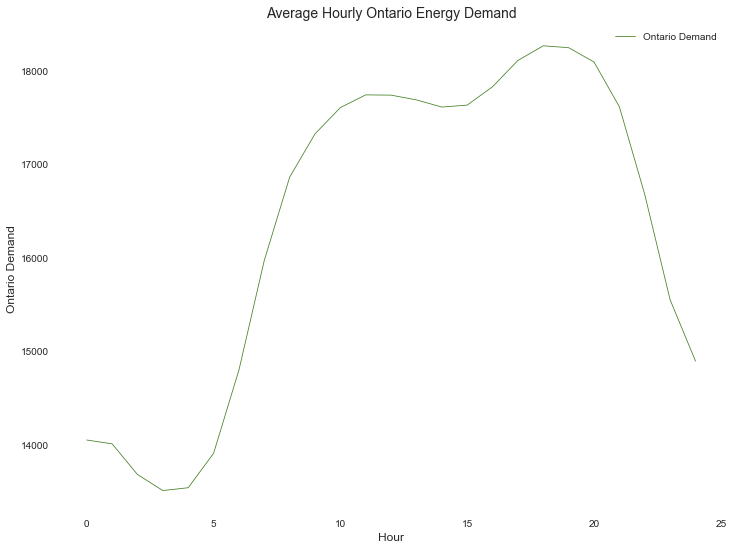

In [29]:
# Let's look at average hourly consumption.
gone=all_data.groupby(["Hour"]).mean().reset_index()
line_plot(gone,"Hour","Ontario Demand", "Ontario Demand",'Average Hourly Ontario Energy Demand','#478329')

Here we see that the demand is lowest on average between 2 and 5 a.m. and then increases rapidly between 5 and 10 as people wake up and go to work. There is a slight decrease from 11 until 3 and then a bigger spike between 16 and 20 when people are generally back at home.

### How does energy demand change throughout the year?

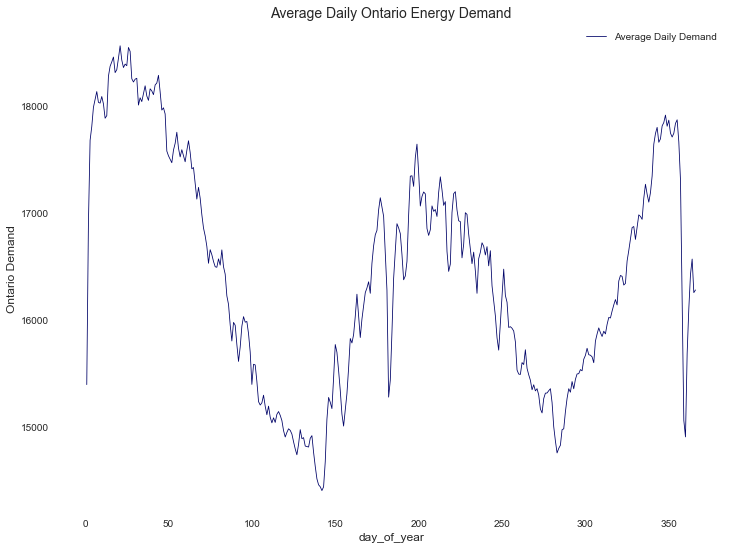

In [30]:
dyear=all_data["Date/Time"].dt.dayofyear
dweek = all_data["Date/Time"].dt.dayofweek
dyear=dyear.rename("day_of_year")
dweek=dweek.rename("day_of_week")
day_data=pd.concat([all_data,dyear,dweek],axis=1)
gtwo=day_data.groupby("day_of_year").mean().reset_index()
line_plot(gtwo,"day_of_year","Ontario Demand", "Average Daily Demand",'Average Daily Ontario Energy Demand', '#000368')

Here we can see that the average energy demand is higher in the winter months and during the summer. In the spring and fall the weather is milder in Ontario so it makes sense that there is less energy demanded for heating and cooling during those months. We see that there are a couple big drops in energy demand. One occurs on the days 182 and 183, which is the holiday Canada Day depending on whether or not the year is a leap year and the other days are 359 and 360, which correspond to Christmas. This makes sense since many businesses are closed on holidays and there is less demand for energy.

### How does energy demand change throughout the week?

C:\Users\MSI_USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


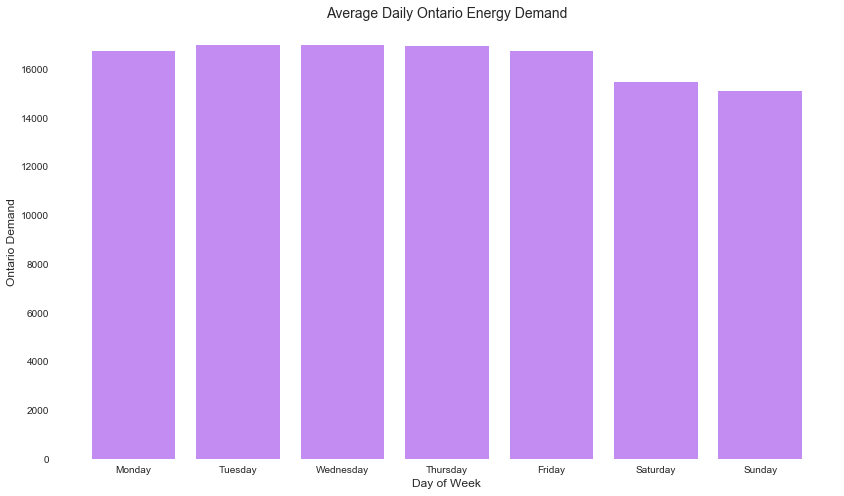

In [31]:
gthree=day_data.groupby("day_of_week").mean().reset_index()
bar_plot(gthree,"Day of Week",["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],"Ontario Demand",'Average Daily Ontario Energy Demand','#881be9')

Demand is clearly less on the weekends than during the week, but also Monday is likely slightly less since many holidays occur on a Monday.

### How has the total energy demanded changed throughout the years?

C:\Users\MSI_USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


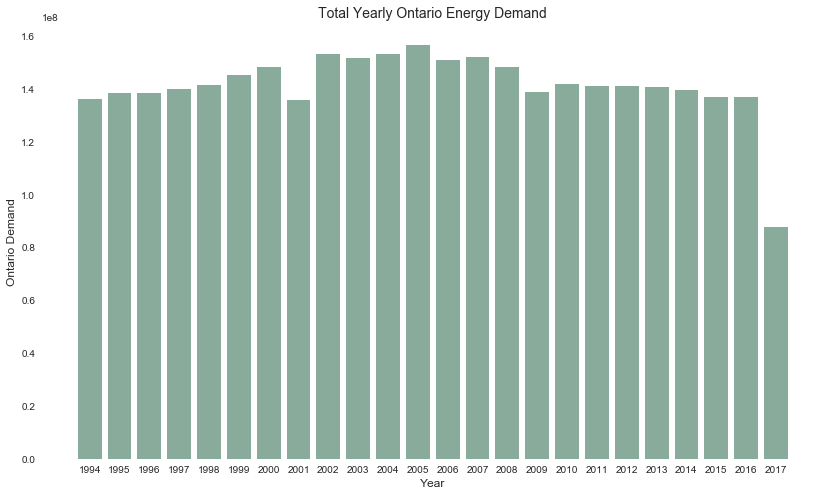

In [32]:
gfour=day_data.groupby("Year").sum().reset_index()
gfour["Year"]=gfour["Year"].astype(int)
bar_plot(gfour,"Year",gfour["Year"],"Ontario Demand",'Total Yearly Ontario Energy Demand','#135938')
gfive=day_data.groupby("Year").mean().reset_index()
#line_plot(gfive,"Year","Temp (°C)","Average Temperature","Average Yearly Temperature for Toronto",'#b02009')

Although 2017 is not over so the total energy demand for this year will certainly be less, we do see a slight decrease in energy over the past few years. The other big difference is in the change from 2001 to 2002. 2002 was the first year that energy was traded on the market.

## Look at the spikes in demand, what can we say about what was happening before? 
Look hour sharp hourly changes in temperature, price, etc affect demand, does the demand drop / increase?
In addition, look into when the biggest changes occur between hourly energy consumption

In [33]:
weather_drop=all_data.sort_values(by="Date/Time").drop(["Year","Month","Day","Wind Dir (10s deg)","Visibility (km)","Hmdx Flag","Wind Chill Flag","Hour"],axis=1)
weather_drop["demand_diff"] = weather_drop["Ontario Demand"].diff()
weather_drop["temp_diff"] = weather_drop["Temp (°C)"].diff()

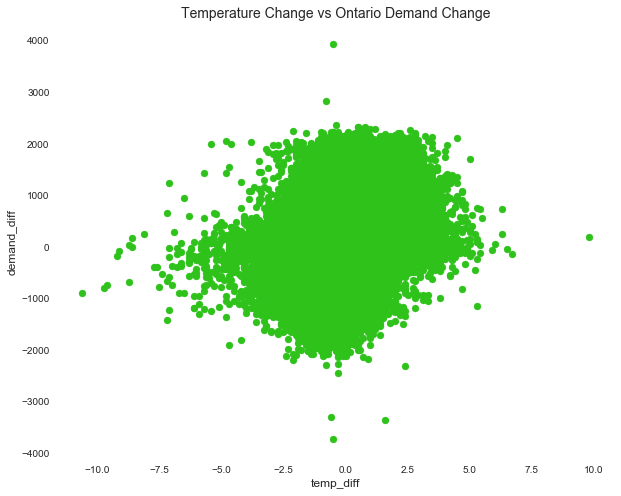

In [34]:
sc_plot(weather_drop.drop(blackout_list),"temp_diff",'demand_diff', '#2ec21b', 'Temperature Change vs Ontario Demand Change')

????

## Rolling Averages
A simple moving average is customizable in that it can be calculated for a different number of time periods, simply by adding the demand for a number of time periods and then dividing this total by the number of time periods, which gives the average demand over the time period. A simple moving average smooths out volatility, and makes it easier to view the demand trend. If the simple moving average points up, this means that the demand is increasing. If it is pointing down it means that the demand is decreasing. The longer the timeframe for the moving average, the smoother the simple moving average. A shorter-term moving average is more volatile, but its reading is closer to the source data.

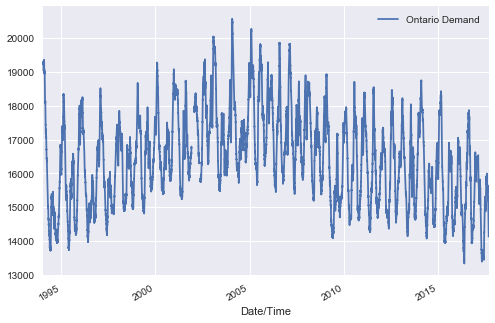

In [51]:
df_rolling = all_data[["Date/Time","Ontario Demand"]].sort_values(by="Date/Time").set_index("Date/Time")#.cumsum()
df_rolling.rolling(window = 500).mean().plot(subplots=True)
#df_rolling.head(10)
plt.show()

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=10,min_periods=10,adjust=True,ignore_na=False).mean()
  if __name__ == '__main__':


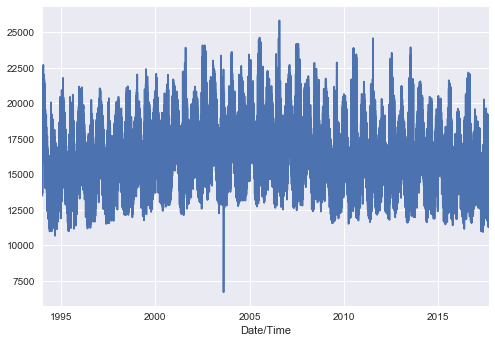

In [52]:
pd.ewma(df_rolling['Ontario Demand'], span = 10, min_periods = 10).plot()
plt.show()

Developed by Gerald Appel in the late seventies, MACD (Moving Average Convergence/Divergence) is one of the simplest and most effective momentum indicators available. MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average. A nine-day EMA of the MACD, called the "signal line", is then plotted on top of the MACD, functioning as a trigger for buy and sell signals. As a result, MACD offers the best of both worlds: trend following and momentum.

To calculate MACD, the formula is:

    MACD: (12-day EMA - 26-day EMA)
    Signal: 9-day EMA of the MACD
    Crossover: MACD - Signal 


In [36]:
df_demand=all_data[["Date/Time","Ontario Demand"]].sort_values(by="Date/Time")
df_demand['26 ema'] = pd.ewma(df_demand["Ontario Demand"], span=26)
df_demand['12 ema'] = pd.ewma(df_demand["Ontario Demand"], span=12)
df_demand['MACD'] = (df_demand['12 ema'] - df_demand['26 ema'])
df_demand['Signal'] = pd.ewma(df_demand['MACD'], span=9)
df_demand['Crossover'] = df_demand['MACD'] - df_demand['Signal']
df_demand.head(10)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
  from ipykernel import kernelapp as app
C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
  app.launch_new_instance()
C:\Users\MSI_USER\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(span=9,min_periods=0,adjust=True,ignore_na=False).mean()


,Date/Time,Ontario Demand,26 ema,12 ema,MACD,Signal,Crossover
133704,1994-01-01 00:00:00,14422.0,14422.000000,14422.000000,0.000000,0.000000,0.000000
133705,1994-01-01 01:00:00,13845.0,14122.403846,14109.458333,-12.945513,-7.191952,-5.753561
133706,1994-01-01 02:00:00,13372.0,13852.791030,13821.628176,-31.162855,-17.016092,-14.146762
133707,1994-01-01 03:00:00,13025.0,13621.376832,13570.163793,-51.213039,-28.600424,-22.612615
133708,1994-01-01 04:00:00,12869.0,13446.897542,13379.660096,-67.237445,-40.094064,-27.143381
133709,1994-01-01 05:00:00,12866.0,13330.548397,13254.813669,-75.734728,-49.754665,-25.980062
133710,1994-01-01 06:00:00,13015.0,13274.429750,13201.300088,-73.129662,-55.670254,-17.459409
133711,1994-01-01 07:00:00,13577.0,13323.181315,13279.702869,-43.478446,-52.740333,9.261887
133712,1994-01-01 08:00:00,13567.0,13359.320596,13336.540467,-22.780129,-45.819377,23.039248
133713,1994-01-01 09:00:00,14130.0,13465.666853,13486.900740,21.233887,-30.795554,52.029441


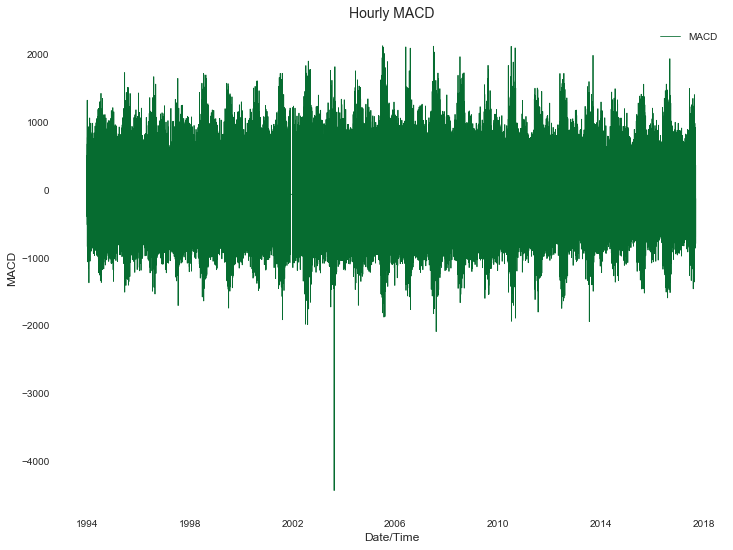

In [37]:
line_plot(df_demand,"Date/Time","MACD", "MACD",'Hourly MACD', '#066c30')

## Look into big changes in temperature from mean for that day 
    
Group data by month, day and hour and find demand average. Then look for times when demand was very far from the mean
    

# Missing values
Our data is somewhat messy with a lot of missing data. We need to find a way to replace the missing data with 
a reasonable guess.

First we remove the columns that are almost entirely NaN's or have letters signifying missing data.

In [16]:
missing_columns=["Data Quality","Temp Flag","Dew Point Temp Flag","Rel Hum Flag","Wind Dir Flag", "Wind Spd Flag",
                 "Visibility Flag","Stn Press Flag","Hmdx Flag","Wind Chill Flag","Date","Hour"]
df_sub=all_data.drop(missing_columns,axis=1)

We first remove the info past August 31, 2017.

In [17]:
df_sub_nosep=df_sub[df_sub["Date/Time"]<"2017-09-01"]
df_sub_nosep.sort_values(by="Date/Time").tail(5)

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),...,Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Ontario_pop,Toronto_pop
133699,2017-08-31 19:00:00,2017.0,8.0,31.0,19:00,15.2,3.8,47.0,NaN,NaN,...,NaN,NaN,NaN,15483.0,17559.0,1.95,628.0,2181.0,13647276.0,6538558.0
133700,2017-08-31 20:00:00,2017.0,8.0,31.0,20:00,14.4,3.6,48.0,NaN,NaN,...,NaN,NaN,NaN,16093.0,18153.0,6.11,1035.0,2162.0,13647276.0,6538558.0
133701,2017-08-31 21:00:00,2017.0,8.0,31.0,21:00,13.9,2.8,47.0,NaN,NaN,...,NaN,NaN,NaN,15537.0,17628.0,3.58,908.0,2188.0,13647276.0,6538558.0
133702,2017-08-31 22:00:00,2017.0,8.0,31.0,22:00,13.1,3.2,51.0,NaN,NaN,...,NaN,NaN,NaN,14539.0,16683.0,0.44,676.0,2188.0,13647276.0,6538558.0
133703,2017-08-31 23:00:00,2017.0,8.0,31.0,23:00,12.0,3.8,57.0,NaN,NaN,...,NaN,NaN,NaN,13349.0,15756.0,2.41,312.0,2451.0,13647276.0,6538558.0


We first use linear interpolation for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns when there is only one hour's worth of data is missing.

In [18]:
df_sub_nosep=df_sub_nosep.sort_values(by="Date/Time").reset_index().drop("index",axis=1)
df_sub_nosep.interpolate(method='linear',limit_direction="forward",limit=1,inplace=True)

When there is more than one hour's worth of missing data we use the previous day's data for the "Temp (°C)", "Dew Point Temp (°C)", "Rel Hum (%)", "Stn Press (kPa)", "Ontario Demand" and "Total Market Demand" columns.

In [19]:
df_sub_nosep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207456 entries, 0 to 207455
Data columns (total 22 columns):
Date/Time              207456 non-null datetime64[ns]
Year                   207456 non-null float64
Month                  207456 non-null float64
Day                    207456 non-null float64
Time                   207456 non-null object
Temp (°C)              206444 non-null float64
Dew Point Temp (°C)    206444 non-null float64
Rel Hum (%)            206444 non-null float64
Wind Dir (10s deg)     71816 non-null float64
Wind Spd (km/h)        75249 non-null float64
Visibility (km)        73722 non-null float64
Stn Press (kPa)        200792 non-null float64
Hmdx                   35313 non-null float64
Wind Chill             17605 non-null float64
Weather                73616 non-null object
Ontario Demand         206713 non-null float64
Total Market Demand    134447 non-null float64
HOEP                   134447 non-null float64
Imports                134447 non-null float

In [20]:
#List the indices where the temperature data is missing.
index_list_temp=df_sub_nosep[df_sub_nosep["Temp (°C)"].isnull()].index
# Replace the missing temperature, dew point temperature and relative humidity data with the previous day's data.
for i in index_list_temp:
    df_sub_nosep.iloc[i,5]=df_sub_nosep.iloc[i-24,5]
    df_sub_nosep.iloc[i,6]=df_sub_nosep.iloc[i-24,6]
    df_sub_nosep.iloc[i,7]=df_sub_nosep.iloc[i-24,7]
#List the indices where the pressure data is missing.
index_list_stn=df_sub_nosep[df_sub_nosep["Stn Press (kPa)"].isnull()].index
# Replace the missing pressure data with the previous day's data.
for i in index_list_stn:
    df_sub_nosep.iloc[i,11]=df_sub_nosep.iloc[i-24,11]
#List the indices where the demand data is missing.
index_list_ont=df_sub_nosep[df_sub_nosep["Ontario Demand"].isnull()].index
# Replace the missing demand data with the previous day's data.
for i in index_list_ont:
    df_sub_nosep.iloc[i,15]=df_sub_nosep.iloc[i-24,15]

We have the following formula for Humidex.
Humidex $${\text{Humidex}}=T_{\text{air}}+0.5555\left[6.11e^{5417.7530\left({\frac {1}{273.16}}-{\frac {1}{273.15+T_{\text{dew}}}}\right)}-10\right]$$
We should look into formulas for wind chill, what to do with no wind given, station pressure, should we interpolate the missing ontario demands and temperatures.

In [21]:
index_list_hmdx=df_sub_nosep[df_sub_nosep["Hmdx"].isnull()].index
for i in index_list_hmdx:
    df_sub_nosep.iloc[i,12]=df_sub_nosep.iloc[i,5]+0.5555*(6.11*np.exp(5417.7530*(1/273.16-1/(273.15+df_sub_nosep.iloc[i,5])))-10).round(decimals=1)

In [22]:
df_sub_nosep.head(10)

,Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),...,Hmdx,Wind Chill,Weather,Ontario Demand,Total Market Demand,HOEP,Imports,Exports,Ontario_pop,Toronto_pop
0,1994-01-01 00:00:00,1994.0,1.0,1.0,00:00,-1.2,-3.8,83.0,20.0,15.0,...,-3.64420,-6.000000,Cloudy,14422.0,NaN,NaN,NaN,NaN,10491271.0,4447904.0
1,1994-01-01 01:00:00,1994.0,1.0,1.0,01:00,-0.9,-3.0,86.0,22.0,20.0,...,-3.28865,-6.000000,Cloudy,13845.0,NaN,NaN,NaN,NaN,10491286.0,4447914.0
2,1994-01-01 02:00:00,1994.0,1.0,1.0,02:00,-0.7,-3.2,83.0,22.0,15.0,...,-3.03310,-5.000000,Cloudy,13372.0,NaN,NaN,NaN,NaN,10491301.0,4447925.0
3,1994-01-01 03:00:00,1994.0,1.0,1.0,03:00,-0.8,-2.4,89.0,20.0,15.0,...,-3.13310,-5.000000,Cloudy,13025.0,NaN,NaN,NaN,NaN,10491316.0,4447935.0
4,1994-01-01 04:00:00,1994.0,1.0,1.0,04:00,-1.0,-3.3,84.0,20.0,19.0,...,-3.38865,-6.000000,Mostly Cloudy,12869.0,NaN,NaN,NaN,NaN,10491331.0,4447945.0
5,1994-01-01 05:00:00,1994.0,1.0,1.0,05:00,-1.8,-3.6,87.0,19.0,11.0,...,-4.35530,-6.000000,Cloudy,12866.0,NaN,NaN,NaN,NaN,10491346.0,4447956.0
6,1994-01-01 06:00:00,1994.0,1.0,1.0,06:00,-1.7,-3.9,85.0,19.0,15.0,...,-4.25530,-7.000000,Cloudy,13015.0,NaN,NaN,NaN,NaN,10491361.0,4447966.0
7,1994-01-01 07:00:00,1994.0,1.0,1.0,07:00,-1.8,-4.8,80.0,15.0,15.0,...,-4.35530,-7.000000,Mostly Cloudy,13577.0,NaN,NaN,NaN,NaN,10491376.0,4447976.0
8,1994-01-01 08:00:00,1994.0,1.0,1.0,08:00,-0.5,-3.8,78.0,18.0,17.0,...,-2.77755,-5.000000,Mostly Cloudy,13567.0,NaN,NaN,NaN,NaN,10491391.0,4447987.0
9,1994-01-01 09:00:00,1994.0,1.0,1.0,09:00,0.5,-3.7,73.0,19.0,24.0,...,-1.55535,-5.055556,Mostly Cloudy,14130.0,NaN,NaN,NaN,NaN,10491406.0,4447997.0


In [23]:
df_sub_nosep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207456 entries, 0 to 207455
Data columns (total 22 columns):
Date/Time              207456 non-null datetime64[ns]
Year                   207456 non-null float64
Month                  207456 non-null float64
Day                    207456 non-null float64
Time                   207456 non-null object
Temp (°C)              207456 non-null float64
Dew Point Temp (°C)    207456 non-null float64
Rel Hum (%)            207456 non-null float64
Wind Dir (10s deg)     71816 non-null float64
Wind Spd (km/h)        75249 non-null float64
Visibility (km)        73722 non-null float64
Stn Press (kPa)        207456 non-null float64
Hmdx                   207456 non-null float64
Wind Chill             17605 non-null float64
Weather                73616 non-null object
Ontario Demand         207456 non-null float64
Total Market Demand    134447 non-null float64
HOEP                   134447 non-null float64
Imports                134447 non-null floa

## VIF Variance Inflation Factor

The Correlation matrix above is used to detect colinearity between two variables. However, multicolinearity is a measurement of correlation from three or more variables and can emerge even when isolated pairs of variables are not colinear.

We use the Variance Inflation Factor (VIF) as a measure of colinearity among predictor variables within a multiple regression. It is given by the formula: $ VIF = 1 / (1 - R^2). $

In [64]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif=df_sub_nosep.rename(columns={'Temp (°C)': 'Temp', 'Dew Point Temp (°C)': 'Dew_Point_Temp', 'Rel Hum (%)': 'Rel_Hum',
                          'Wind Dir (10s deg)':"Wind_Dir","Wind Spd (km/h)":"Wind_Spd","Visibility (km)":"Visibility",
                           'Stn Press (kPa)':'Stn_Press','Wind Chill':"Wind_Chill","Total Market Demand":"Total_Market_Demand",
                           "Ontario Demand":"Ontario_Demand"})
linear_feature_cols = ['Temp','Dew_Point_Temp','Rel_Hum','Wind_Dir','Wind_Spd',
                       'Visibility','Stn_Press','Hmdx','Wind_Chill','Total_Market_Demand','HOEP','Imports',
                       'Exports','Ontario_pop','Toronto_pop']
feature_cols_str = "+".join(linear_feature_cols)
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('Ontario_Demand ~' + feature_cols_str, df_vif, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

C:\Users\MSI_USER\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1181: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\MSI_USER\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,0.000000,Intercept
1,inf,Temp
2,inf,Dew_Point_Temp
3,inf,Rel_Hum
4,0.000000,Wind_Dir
5,inf,Wind_Spd
6,0.000000,Visibility
7,inf,Stn_Press
8,inf,Hmdx
9,0.000000,Wind_Chill


We see that since some features are extremely correlated we are getting an infinite value for the VIF Factor. We remove Dew_point_Temp, Rel_Hum,Total_Market_Demand and Toronto_pop.

In [65]:
linear_feature_cols_sub = ['Temp','Wind_Dir','Wind_Spd','Visibility','Stn_Press','Hmdx','Wind_Chill','HOEP','Imports',
                       'Exports','Ontario_pop']
feature_cols_str = "+".join(linear_feature_cols_sub)
# get y and X dataframes based on this regression:
y_vif, X_vif = dmatrices('Ontario_Demand ~' + feature_cols_str, df_vif, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns
vif

C:\Users\MSI_USER\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1181: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\MSI_USER\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,0.000000,Intercept
1,inf,Temp
2,0.000000,Wind_Dir
3,inf,Wind_Spd
4,0.000000,Visibility
5,inf,Stn_Press
6,inf,Hmdx
7,0.000000,Wind_Chill
8,inf,HOEP
9,inf,Imports


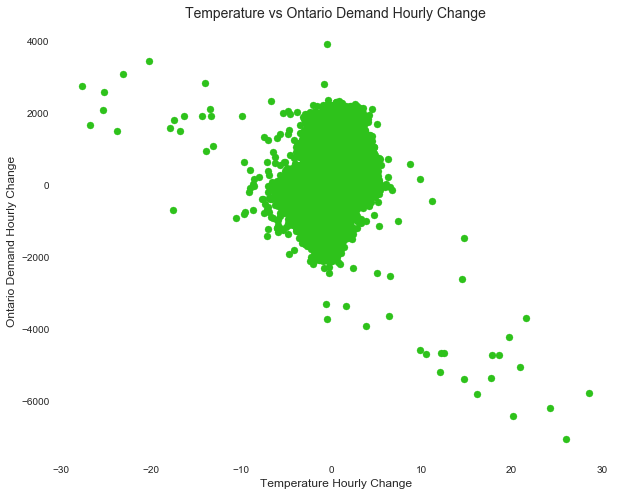

There seems to be some interesting very high spikes in energy demand when the temperature decreases rapidly. Conversely, when the weather warms rapidly there is significant decrease in the energy demand. 

## More Missing values
Set  "Wind Dir (10s deg)","Wind Spd (km/h)" to zero since 68% of the time the wind speed is zero.
Set "Visibility (km)" to 24.1 since 70% of entries have this as the visibility.

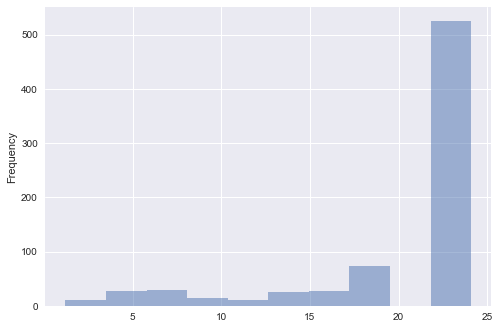

In [67]:
df_ml["Visibility (km)"].plot.hist(alpha=0.5)
plt.show()

In [68]:
len(df_ml[df_ml["Visibility (km)"]>24])/len(df_ml[df_ml["Visibility (km)"].notnull()])

0.7056451612903226

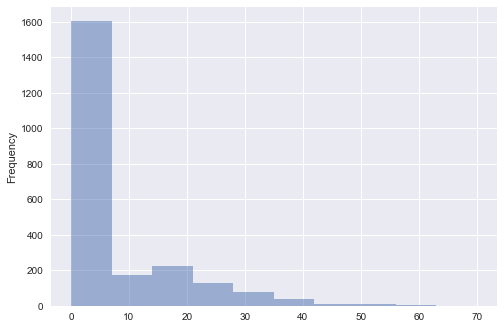

In [71]:
df_ml["Wind Spd (km/h)"].plot.hist(alpha=0.5)
plt.show()

In [72]:
len(df_ml[df_ml["Wind Spd (km/h)"]<1])/len(df_ml[df_ml["Wind Spd (km/h)"].notnull()])

0.6811977102597975

In [73]:
len(df_ml[df_ml["Wind Spd (km/h)"].notnull()])

2271

In [76]:
len(df_ml[df_ml["Visibility (km)"].notnull()])

744

# Machine Learning Section

Since the Ontario Energy Market opened in May 1, 2002, we only use data from this point onwards for the modeling section.

Look into forecasting demand for the month of August and compare at the end of the month.

In [26]:
df_ml=df_sub_nosep[df_sub_nosep["Date/Time"]>"2002-05-01"].drop(["Year","Month","Day","Time",'Weather'],axis=1)

In [35]:
# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.grid_search import GridSearchCV
#from sklearn.metrics import classification_report
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error

We write the program to split the train and test sets, gridsearch and cross-validation.

In [46]:
def do_regression(model, df, parameters, featurenames, targetname, seed = 7):
    # Create the 'X' and 'y' datasets
    X=df[featurenames].values
    y=df[targetname].values
    # Split X and y into training and test data.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=seed)
    model = model()
    # Now implement GridSearchCV
    grid_model = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=1)
    # Fit the training data to find the best estimator.
    grid_model.fit(Xtrain, ytrain)
    grid_est=grid_model.best_estimator_
    print("BEST PARAMS", grid_model.best_params_)
    # Now perform K-Fold Cross-Validation on model with tuned parameters to test for over-fitting
    kf_total = KFold(n_splits=5,shuffle=True, random_state=seed)
    max_score = 0
    for train, test in kf_total.split(X): # split data into train/test groups, 5 times
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        model_fitted = grid_est.fit(X_train,y_train)
        fold_score=model_fitted.score(X_test,y_test)
        print("Cross-validation score: ", fold_score)
        if fold_score>max_score:
            best_model=model_fitted
    # Now use the best model to find the accuracy on the test data
    training_accuracy = best_model.score(Xtrain, ytrain)
    test_accuracy = best_model.score(Xtest, ytest)
    print("")
    print("Accuracy on training data: {:0.5f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.5f}".format(test_accuracy))
    # Compare prediction with the test data
    test_prediction=best_model.predict(Xtest)
    #print(ytest.astype(float))
    #print(test_prediction.astype(float))
    print("")
    print("Explained variance score: ",explained_variance_score(ytest,test_prediction))
    print("Mean absolute error: ",mean_absolute_error(ytest, test_prediction))
    print("Mean squared error: ",mean_squared_error(ytest, test_prediction))
    #print("Mean squared log error: ",mean_squared_log_error(ytest, test_prediction))
    print("Median absolute error: ",median_absolute_error(ytest, test_prediction))
    rscore_list = ['variance_weighted','uniform_average','raw_values']
    print("")
    for rs in rscore_list:
        print("R^2 " +rs +": ",  r2_score(ytest, test_prediction, multioutput=rs))
    #print(precision_recall_fscore_support(ytest,test_prediction))
    #print(classification_report(ytest,test_prediction,target_names=targetname))
    return best_model,ytest,test_prediction

## Linear Regression

In [29]:
all_feature_cols=["Date/Time","Year","Month","Day", "Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)", "Wind Dir (10s deg)","Wind Spd (km/h)", "Visibility (km)", "Stn Press (kPa)","Hmdx", "Wind Chill", "HOEP","Imports","Exports", "Ontario_pop","Toronto_pop"]

In [45]:
linear_feature_cols=["Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Stn Press (kPa)","Hmdx", "HOEP","Imports","Exports", "Ontario_pop","Toronto_pop"]
from sklearn.linear_model import LinearRegression
params={"fit_intercept":[True,False],"normalize":[True,False]}
linear_reg,true_dat,predicted_dat=do_regression(LinearRegression,df_ml,params,linear_feature_cols,"Ontario Demand",7)

BEST PARAMS {'fit_intercept': True, 'normalize': True}
Cross-validation score:  0.431680814299
Cross-validation score:  0.410171510195
Cross-validation score:  0.415075960068
Cross-validation score:  0.417397863782
Cross-validation score:  0.405737959786

Accuracy on training data: 0.41219
Accuracy on test data:     0.43329

Explained variance score:  0.43330410274
Mean absolute error:  1571.13153609
Mean squared error:  3887820.26341
Median absolute error:  1348.33202561

R^2 variance_weighted :  0.433285811043
R^2 uniform_average :  0.433285811043
R^2 raw_values :  [ 0.43328581]


In [47]:
pd.DataFrame({"feature":linear_feature_cols,"linear_coefficient":linear_reg.coef_})

,feature,linear_coefficient
0,Temp (°C),-28.219367
1,Dew Point Temp (°C),141.722784
2,Rel Hum (%),-52.312552
3,Stn Press (kPa),-280.786577
4,Hmdx,-96.747790
5,HOEP,31.267324
6,Imports,1.294494
7,Exports,-0.433926
8,Ontario_pop,-0.006244
9,Toronto_pop,0.009637


Explain findings here.

## Ridge Regression
Explain ridge regression here.

In [48]:
from sklearn.linear_model import Ridge
params={ "alpha":[0.001,0.01,0.1,1,10], "fit_intercept":[True,False],"normalize":[True,False]}
linear_ridge,true_dat,predicted_dat=do_regression(Ridge,df_ml,params,linear_feature_cols,"Ontario Demand",7)

BEST PARAMS {'alpha': 10, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.431680664085
Cross-validation score:  0.410171499131
Cross-validation score:  0.415075945182
Cross-validation score:  0.417397953495
Cross-validation score:  0.40573807929

Accuracy on training data: 0.41219
Accuracy on test data:     0.43329

Explained variance score:  0.433304009767
Mean absolute error:  1571.13237456
Mean squared error:  3887820.90584
Median absolute error:  1348.29572324

R^2 variance_weighted:  0.433285717398
R^2 uniform_average:  0.433285717398
R^2 raw_values:  [ 0.43328572]


In [49]:
pd.DataFrame({"feature":linear_feature_cols,"linear_coefficient":linear_ridge.coef_})

,feature,linear_coefficient
0,Temp (°C),-28.185388
1,Dew Point Temp (°C),141.682586
2,Rel Hum (%),-52.302837
3,Stn Press (kPa),-280.737104
4,Hmdx,-96.744062
5,HOEP,31.267301
6,Imports,1.294494
7,Exports,-0.433926
8,Ontario_pop,-0.006244
9,Toronto_pop,0.009637


Explain findings here.

## Ridge Lasso Regression
Explain Ridge Lasso Regression Here.

In [53]:
from sklearn.linear_model import Lasso
params={ "alpha":[1,3], "fit_intercept":[True,False],"normalize":[True,False]}
linear_lasso,true_dat,predicted_dat=do_regression(Lasso,df_ml,params,linear_feature_cols,"Ontario Demand",7)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might wa

BEST PARAMS {'alpha': 1, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.431138658
Cross-validation score:  0.409772600774
Cross-validation score:  0.415245857727
Cross-validation score:  0.416868886465
Cross-validation score:  0.405434043748

Accuracy on training data: 0.41191
Accuracy on test data:     0.43277

Explained variance score:  0.432787214578
Mean absolute error:  1572.33678915
Mean squared error:  3891362.39215
Median absolute error:  1349.96595392

R^2 variance_weighted:  0.432769487118
R^2 uniform_average:  0.432769487118
R^2 raw_values:  [ 0.43276949]


In [54]:
pd.DataFrame({"feature":linear_feature_cols,"linear_coefficient":linear_lasso.coef_})

,feature,linear_coefficient
0,Temp (°C),-22.751823
1,Dew Point Temp (°C),136.099135
2,Rel Hum (%),-50.752073
3,Stn Press (kPa),-278.813307
4,Hmdx,-96.795590
5,HOEP,31.304204
6,Imports,1.277166
7,Exports,-0.439315
8,Ontario_pop,-0.003411
9,Toronto_pop,0.005388


Looks very similar to regular linear regression. Investigate how to tune it.

## Elastic Net
Explain Elastic Net here.

In [55]:
from sklearn.linear_model import ElasticNet
params={ "alpha":[1,5,10], "fit_intercept":[True,False],"normalize":[True,False]}
linear_enet,true_dat,predicted_dat=do_regression(ElasticNet,df_ml,params,linear_feature_cols,"Ontario Demand",7)

C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\MSI_USER\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might wa

BEST PARAMS {'alpha': 1, 'fit_intercept': True, 'normalize': False}
Cross-validation score:  0.428978566942
Cross-validation score:  0.407432748024
Cross-validation score:  0.413603792199
Cross-validation score:  0.415222424782
Cross-validation score:  0.403828694402

Accuracy on training data: 0.41011
Accuracy on test data:     0.43065

Explained variance score:  0.430673823388
Mean absolute error:  1577.62395526
Mean squared error:  3905871.00231
Median absolute error:  1356.11753778

R^2 variance_weighted:  0.430654616912
R^2 uniform_average:  0.430654616912
R^2 raw_values:  [ 0.43065462]


In [56]:
pd.DataFrame({"feature":linear_feature_cols,"linear_coefficient":linear_enet.coef_})

,feature,linear_coefficient
0,Temp (°C),15.637980
1,Dew Point Temp (°C),63.233050
2,Rel Hum (%),-32.775008
3,Stn Press (kPa),-146.850231
4,Hmdx,-72.328469
5,HOEP,31.206301
6,Imports,1.278698
7,Exports,-0.441135
8,Ontario_pop,-0.003422
9,Toronto_pop,0.005389


Dew Point Temperature is much less indicative here.

## Random Forest Regressor
Explain Random Forest here.

In [57]:
from sklearn.ensemble import RandomForestRegressor
params={'n_estimators':[250,500],'max_depth':[3,5]}
rf_model,true_dat,predicted_dat=do_regression(RandomForestRegressor,df_ml,params,linear_feature_cols,"Ontario Demand",7)

BEST PARAMS {'max_depth': 5, 'n_estimators': 250}
Cross-validation score:  0.625427001595
Cross-validation score:  0.62189548156
Cross-validation score:  0.627789066081
Cross-validation score:  0.62178023033
Cross-validation score:  0.628395717822

Accuracy on training data: 0.62657
Accuracy on test data:     0.62685

Explained variance score:  0.62685223116
Mean absolute error:  1291.69119026
Mean squared error:  2559903.96703
Median absolute error:  1111.42166018

R^2 variance_weighted:  0.626851602648
R^2 uniform_average:  0.626851602648
R^2 raw_values:  [ 0.6268516]


In [58]:
pd.DataFrame({"feature":linear_feature_cols,"feature_importance":rf_model.feature_importances_})

,feature,feature_importance
0,Temp (°C),0.171184
1,Dew Point Temp (°C),0.003501
2,Rel Hum (%),0.000022
3,Stn Press (kPa),0.000358
4,Hmdx,0.040968
5,HOEP,0.710897
6,Imports,0.044211
7,Exports,0.002552
8,Ontario_pop,0.012820
9,Toronto_pop,0.013487


Explain findings here.

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
params={'C':[1,10],'epsilon':[0.1,0.5]}
svr_model,true_dat,predicted_dat=do_regression(SVR,df_ml,params,linear_feature_cols,"Ontario Demand",7)

In [ ]:
pd.DataFrame({"feature":linear_feature_cols,"feature_importance":svr_model.coef_})

Explain findings here.

## K-Nearest Neighbors Regression
Explain K-NN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
params={'n_neighbors':[3,5,7],'algorithm': ['ball_tree', 'kd_tree'],'leaf_size':[10,30,50]}
knn_model,true_dat,predicted_dat=do_regression(KNeighborsRegressor,df_ml,params,linear_feature_cols,"Ontario Demand",7)

In [ ]:
knn_model.kneighbors_graph(true_dat)

Explain findings here.

## Gradient Boosted Regression
Explain GBR.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
params = {'learning_rate':[0.1,1,10],'n_estimators':[50,100,200],'max_depth':[3,5],'min_samples_leaf':[1,3]}
gbr_model,true_dat,predicted_dat=do_regression(GradientBoostingRegressor,df_ml,params,linear_feature_cols,"Ontario Demand",7)

In [ ]:
pd.DataFrame({"feature":linear_feature_cols,"feature_importance":gbr_model.feature_importances_})

Explain findings here.

## Neural Networks 
Take previous neural network explanation.

In [ ]:
from sklearn.neural_network import MLPRegressor
params={'hidden_layer_sizes'=(8,8,8),'learning_rate':[0.1,1,10]}
nn_model,true_dat,predicted_dat=do_regression(MLPRegressor,df_ml,params,linear_feature_cols,"Ontario Demand",7)

In [ ]:
pd.DataFrame({"feature":linear_feature_cols,"feature_importance":nn_model.coefs_})

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
def cv_score(clf, x, y, nfold=5):
    max_score = 0
    best_model=clf
    kf = KFold(n_splits=nfold,shuffle=True)
    for train, test in kf.split(x): # split data into train/test groups, 5 times
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        clf_fitted=clf.fit(X_train, y_train) # fit
        clf_score=clf_fitted.score(X_test,y_test)
        if clf_score>max_score:
            best_model=clf_fitted
        #print(clf_score)
    return(clf_fitted)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
linear_feature_cols=["Temp (°C)","Dew Point Temp (°C)","Rel Hum (%)","Stn Press (kPa)","Hmdx", "HOEP","Imports","Exports", "Ontario_pop","Toronto_pop"]

kf = KFold(n_splits=4,shuffle=True)
X=df_ml[linear_feature_cols].values
avg_mse=0
for train, test in kf.split(X):
    y=df_ml["Ontario Demand"].values
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    test_prediction=lm.predict(X_test)
    msetest = np.mean((y_test - test_prediction) ** 2)
    avg_mse+=msetest
    print ("The mean squared error of the test data is ", msetest)
print("The average mean squared error is ", avg_mse/4)